# Analysis packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

# Load the data

In [6]:
trainset = pd.read_csv('../PortoSeguro/train_reduce2.csv')
testset  = pd.read_csv('../PortoSeguro/test_reduce2.csv')

# Few quick observations

* Few **groups** are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The **ind** indicates most probably **individual, reg** is probably **registration, car** is self-explanatory, **calc** suggests a **calculated** field;
* The postfix **bin** is used for binary features;
* The postfix **cat** to is used for categorical features;
* Features without the **bin** or **cat** indications are real numbers (continous values) of integers (ordinal values);
* A missing value is indicated by **-1**;
* The value that is subject of prediction is in the **target** column. This one indicates whether or not a claim was filed for that insured person;
* **id** is a data input ordinal number.   

In [7]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the cat values are categorical, integer values ranging from 0 to n, bin values are binary (either 0 or 1).

In [8]:
print("Train dataset (rows, cols):", trainset.shape, "\nTest dataset (rows, cols):", testset.shape)

Train dataset (rows, cols): (49999, 59) 
Test dataset (rows, cols): (49999, 58)


In [10]:
print("Columns in train and not in test dataset:", set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


# Introduction of metadata

To make easier the manipulation of data, we will associate few meta-information to   
the variables in the trainset. This will facilitate the selection of various types of   
features for analysis, inspection or modeling. We are using as well a **category** field   
for the **car, ind, reg and calc** types of features.

What metadata will be used:  
* use: input, ID, target  
* type: nominal, interval, ordinal, binary  
* preserve: True or False  
* dataType: int, float, char  
* category: ind, reg, car, calc

In [20]:
data = []
for feature in trainset.columns:
    # Defining th role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
    
    # Initialize preserve to True for all variables except ofr id 
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category 
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # Creating a Dict that contains all the metadata for the variable 
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [19]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [25]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [22]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


# Data analysis and statistics

## Target variable

<Figure size 432x288 with 0 Axes>

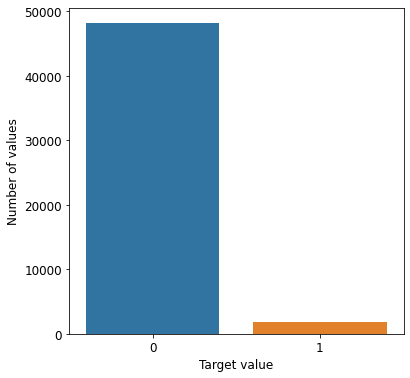

In [29]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value',     fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced.   
We can either undersample the records with target = 0 or oversample records with target = 1;   
because is a large dataset, we will do undersampling of records with target = 0.

### Real features

In [30]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,0.611226,0.440497,0.549426,0.379991,0.812828,0.276137,3.066704,0.450843,0.450473,0.450305
std,0.288883,0.402725,0.796256,0.058344,0.223337,0.357453,0.731325,0.287274,0.286753,0.287392
min,0.000000,0.000000,-1.000000,0.141421,0.313241,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.523510,0.316228,0.671721,0.332265,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.721976,0.374166,0.765811,0.368782,3.316625,0.500000,0.500000,0.500000
75%,0.900000,0.600000,1.004054,0.400000,0.905584,0.397492,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,3.197753,1.264911,2.707275,0.636396,3.741657,0.900000,0.900000,0.900000


In [31]:
(pow(trainset['ps_car_12']*12,2)).head(10)

0    23.0400
1    14.4000
2    14.4000
3    20.1600
4    14.3856
5    28.6416
6    14.4000
7    28.7712
8    23.0400
9    28.8000
Name: ps_car_12, dtype: float64

In [33]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Features with missing values ###    
**ps_reg_03, ps_car_12, ps_car_14** have missing values (their minimum value is -1)  
   
### Registration features  ###   
**ps_reg_01 and ps_reg_02** are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )  
  
### Car features ###   
**ps_car_12** are (with some approximations) square roots (divided by 10) of natural  
numbers whilst **ps_car_15** are square roots of natural numbers. Let's represent the values using pairplot.

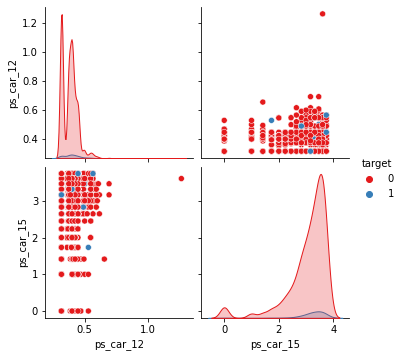

In [36]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Calculated features  
The features **ps_calc_01, ps_calc_02 and ps_calc_03** have very similar distributions   
and could be some kind of ratio, since the maximum value is for all three 0.9.   
The other calculated values have maximum value an integer value (5,6,7, 10,12).

<Figure size 432x288 with 0 Axes>

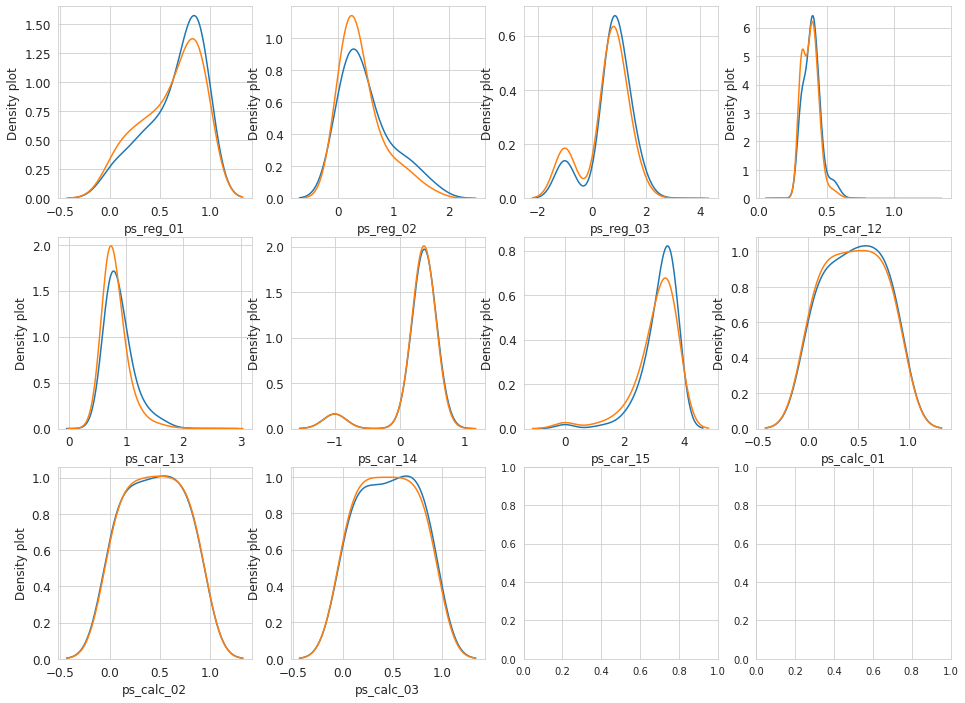

In [54]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks() 
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_reg_02, ps_car_13, ps_car_15** shows the most different distributions between  
sets of values associated with target=0 and target=1.

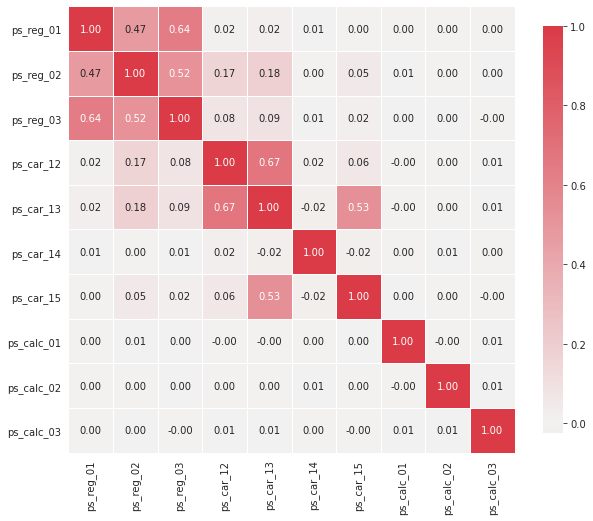

In [57]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # Create color map ranging between two ccolors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, 
                cbar_kws={"shrink": .75})
    plt.show()


var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

* ps_reg_01 with ps_reg_02 (0.47);
* ps_reg_01 with ps_reg_03 (0.64);
* ps_reg_02 with ps_reg_03 (0.52);
* ps_car_12 with ps_car_13 (0.67);
* ps_car_13 with ps_car_15 (0.53);

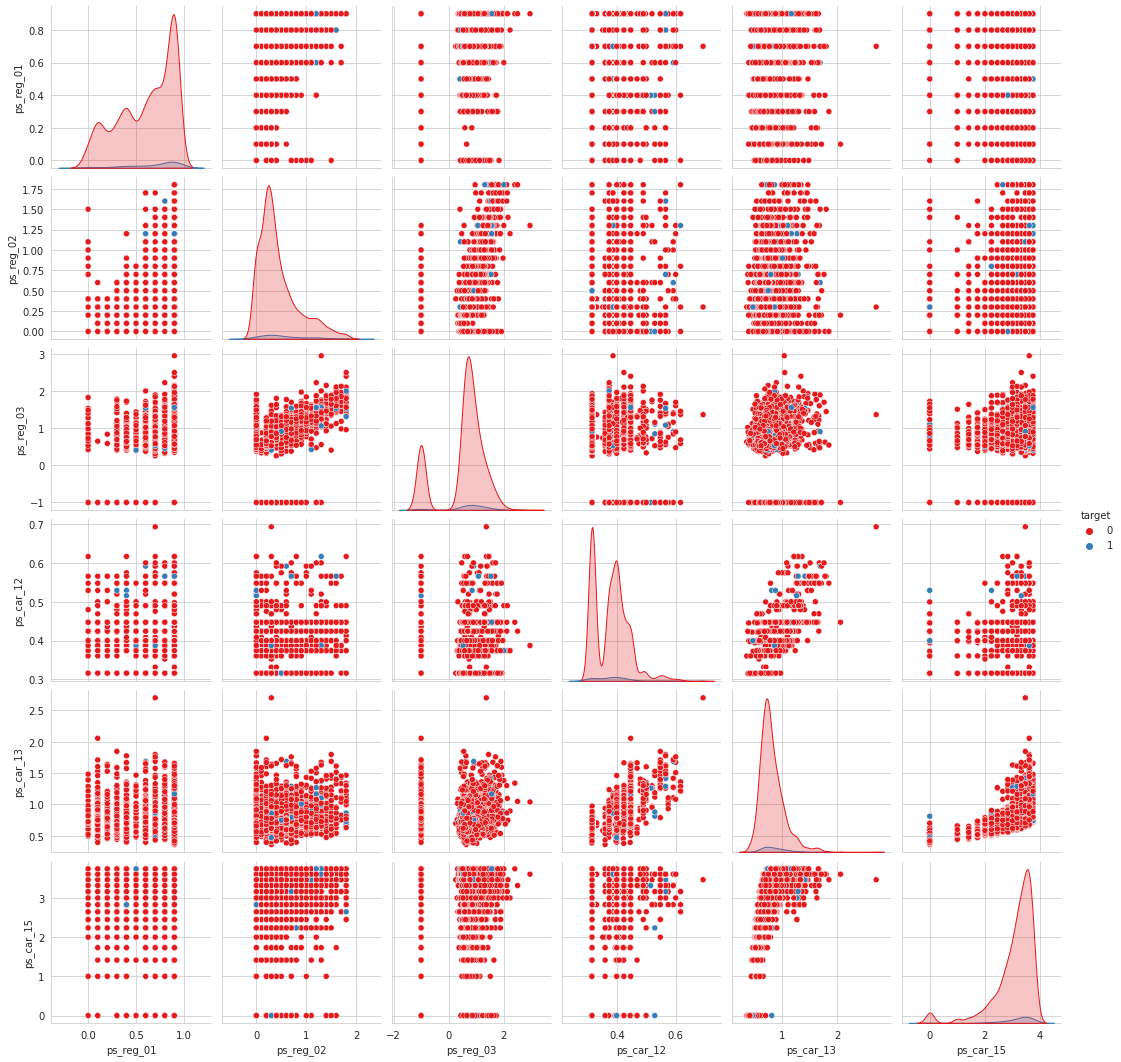

In [75]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

# Binary features

In [76]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,0.036661,0.393888,0.255345,0.164083,0.186684,0.000400,0.001860,0.009640,0.000820,0.662073,0.120102,0.151803,0.123282,0.630293,0.556051,0.288846,0.351347,0.153843
std,0.187929,0.488615,0.436059,0.370355,0.389661,0.019996,0.043088,0.097711,0.028624,0.473008,0.325084,0.358833,0.328764,0.482730,0.496853,0.453231,0.477396,0.360802
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-80-ad12acfd728f>:18: UserWarning: Legend does not support <AxesSubplot:xlabel='Binary features', ylabel='Percent of zero/one [%]'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend((p1, p2), ('Zero', 'One'))


<Figure size 432x288 with 0 Axes>

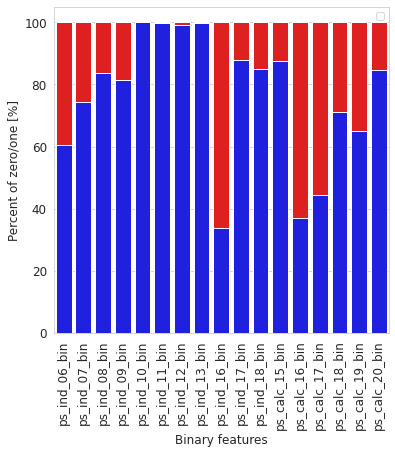

In [80]:
bin_col   = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list  = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

# Bar plot 
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

**ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin** have very small   
number of values 1 (lesss than 0.5%) whilst the number of value 1 is very large for  
**ps_ind_16_bin and ps_cals_16_bin** (more than 60%).

<Figure size 432x288 with 0 Axes>

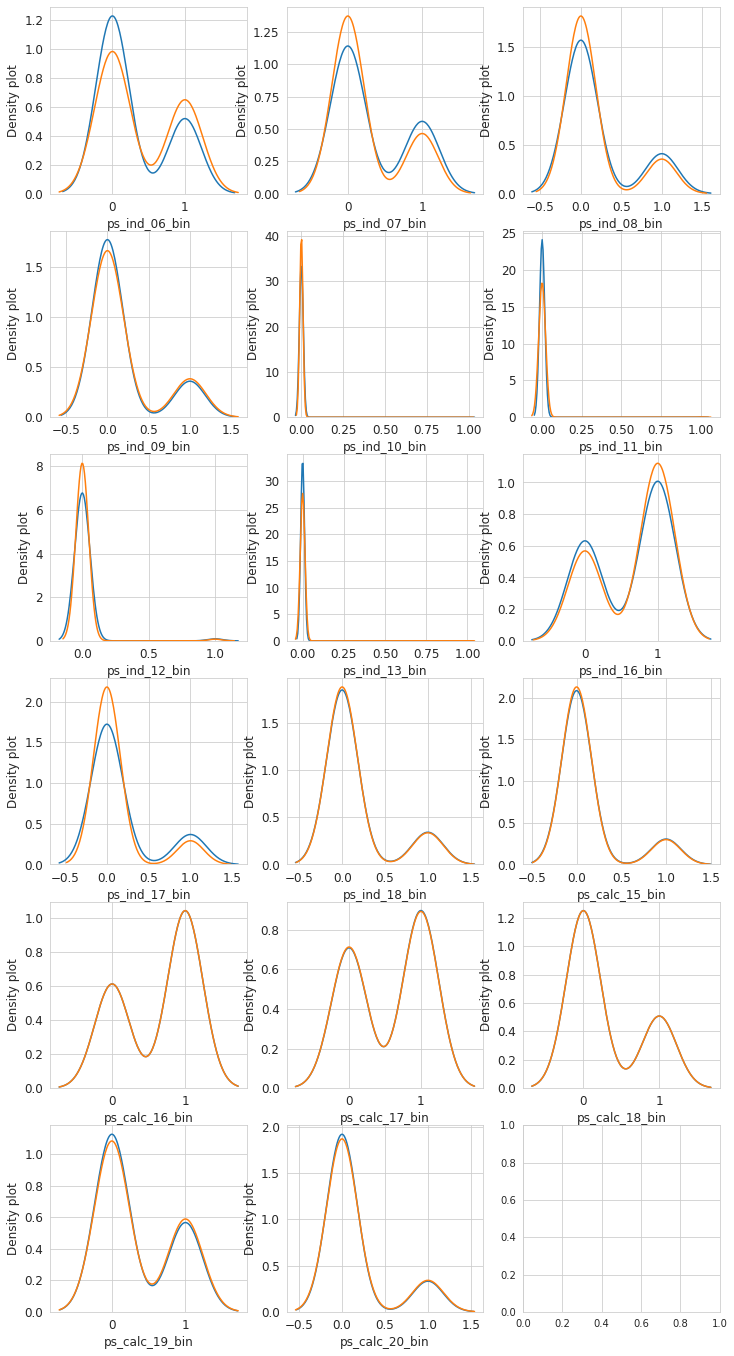

In [94]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw_method=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw_method=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    #plt.legend([line1, line2],['target = 1', 'target = 0'])

plt.show()